# Day 6

### BUSI 520: Python for Business Research
### Kerry Back, JGSB, Rice University

### Overview 

- Artificial dataset
- Lasso 
- Out of sample forecasting
- Diebold-Mariano test
- Validation and cross-validation
- Ridge
- California housing data on Julius

### Some toy data

 - 100 predictive variables (features) and 1000 observations
 - Only 10 of the 100 features are actually predictive
    - The other 90 features are noise
    - The 10 predictive features are the first 10 features
- The left-hand side (target) variable is a linear combination of the 10 predictive features.

In [16]:
import numpy as np 

np.random.seed(0) # just so we all get the same results

X = np.random.normal(size=(1000, 100))
y = X[:, :10].sum(axis=1) + 10 * np.random.normal(size=1000)

In [17]:
# Try OLS

import statsmodels.api as sm 
import pandas as pd

model = sm.OLS(endog=y, exog=sm.add_constant(X))
result = model.fit()
tvalues = pd.Series(result.tvalues)

# significant features 
tvalues[tvalues > 2]

1     3.893511
2     3.977730
3     2.846583
4     2.837924
5     3.382157
6     3.654197
7     2.517688
8     3.355748
9     2.768420
10    2.926688
33    2.259072
35    2.481969
95    2.350388
dtype: float64

In [18]:
# coefficients of first 20 features 
result.params[1:21]

array([ 1.28003538,  1.29619223,  0.90471389,  0.91860977,  1.1069583 ,
        1.22942272,  0.82773064,  1.14865406,  0.89821728,  0.9811078 ,
        0.05494361, -0.30977471, -0.81276878, -0.18962315,  0.15576422,
       -0.19575052, -0.03620061,  0.43368138,  0.0599448 ,  0.20188705])

## Goal of machine learning

- The goal is to make predictions on new data.
- The test of a model is how well it predicts out of sample.
- Can we predict with OLS?

### Diebold-Mariano test 

- Compute mean-squared predictions errors for model (can use different loss function than squared error)
- Compute mean-squared prediction errors for benchmark forecast 
- Do a one-sided $t$ test of the null hypothesis that the model is not better than the benchmark forecast
- Hope to reject the null hypothesis

In [19]:
# some new (test) data from the same data generating process

X_test = np.random.normal(size=(200, 100))
y_test = X_test[:, :10].sum(axis=1) + 10 * np.random.normal(size=200)

In [20]:
# Diebold-Mariano test

# !pip install dieboldmariano 
from dieboldmariano import dm_test

# compare to a benchmark of zero 
benchmark_predict = np.zeros_like(y_test) 
model_predict = result.predict(sm.add_constant(X_test))
dm_test(y_test, model_predict, benchmark_predict, one_sided=True)

(np.float64(-0.5296622926168975), np.float64(0.29846825225075657))

In [23]:
# compare to a benchmark of the out-of-sample target mean
# unfair but common 

benchmark_predict = np.repeat(y_test.mean(), len(y_test))
dm_test(y_test, model_predict, benchmark_predict, one_sided=True)

(np.float64(-0.5109180851771397), np.float64(0.30498738035359785))

### Lasso

- OLS minimizes the mean squared error.  Lasso is an example of penalized linear regression.  It chooses coefficients to minimize

$$\frac{1}{2}\text{MSE} + \text{penalty} \times \sum_{i=1}^n |\beta_i|$$

- The penalty is a hyperparameter.  It is called "alpha" (not the regression intercept).

- The larger the penalty, the smaller the estimated betas will be.  For large alpha, the estimated betas will be zeros.
- Lasso is a way to do "automatic feature selection."  Features are variables used to predict.  Dropping variables with zero lasso betas may be a reasonable thing to do in some settings.

- scikit-learn' Lasso includes an intercept by default.  We can turn it off. The intercept is returned as .intercept_.  The other coefficients are returned as .coef_.

In [24]:
# fit Lasso 

from sklearn.linear_model import Lasso 
model = Lasso(alpha=1)
model.fit(X, y)

Lasso(alpha=1)

In [57]:
# first twenty coefficients (excluding intercept) 

model.coef_[:20]

array([ 0.79639728,  0.41262863,  1.14203814,  0.52133762,  1.31402738,
        0.82636546,  0.98171983,  0.91782699,  0.456659  ,  0.90460806,
        0.22987108,  0.        , -0.14828462,  0.        , -0.11832466,
       -0.        ,  0.        ,  0.        ,  0.24302983, -0.07111992])

In [27]:
# score method computes R2 relative to test sample mean  

help(model.score)

Help on method score in module sklearn.base:

score(X, y, sample_weight=None) method of sklearn.linear_model._coordinate_descent.Lasso instance
    Return the coefficient of determination of the prediction.

    The coefficient of determination :math:`R^2` is defined as
    :math:`(1 - \frac{u}{v})`, where :math:`u` is the residual
    sum of squares ``((y_true - y_pred)** 2).sum()`` and :math:`v`
    is the total sum of squares ``((y_true - y_true.mean()) ** 2).sum()``.
    The best possible score is 1.0 and it can be negative (because the
    model can be arbitrarily worse). A constant model that always predicts
    the expected value of `y`, disregarding the input features, would get
    a :math:`R^2` score of 0.0.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Test samples. For some estimators this may be a precomputed
        kernel matrix or a list of generic objects instead with shape
        ``(n_samples, n_samples_fitted)``, where ``

In [26]:
# compute model score on test data 

model.score(X_test, y_test)

0.002859434185740306

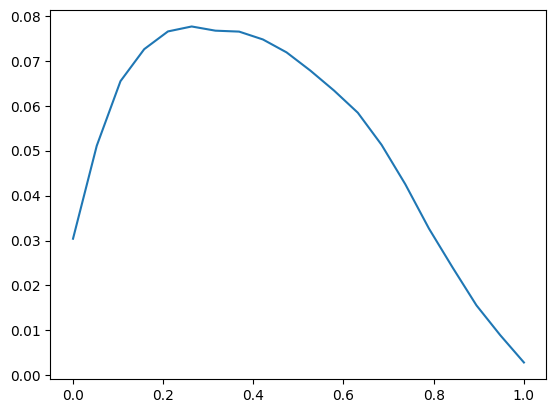

In [32]:
# compute out-of-sample R2's for a range of alphas

grid = np.linspace(0.001, 1, 20)
scores = []
for alpha in grid:
    model = Lasso(alpha=alpha)
    model.fit(X, y)
    scores.append(model.score(X_test, y_test))

import matplotlib.pyplot as plt
plt.plot(grid, scores)

In [33]:
# Diebold-Mariano test 

best_alpha = grid[np.argmax(scores)]
model = Lasso(alpha=best_alpha)
model.fit(X, y)
model_predict = model.predict(X_test)
dm_test(y_test, model_predict, benchmark_predict, one_sided=True)

(np.float64(-2.0249665093950453), np.float64(0.02210338426259904))

### Train, Validate, and Test

Split the data into three parts.  

1. Train on the training data.
2. Evaluate performance on the validation data (playing the role of the test data in our first example).  Choose the best performing model.
3. Test the performance of the chosen model on the test data (held out from training and validation).

In [50]:
# full hypothetical sample 
X = np.random.normal(size=(1500, 100))
y = 100 + X[:, :10].sum(axis=1) + 10 * np.random.normal(size=1500)

# randomly split into training and test samples
from sklearn.model_selection import train_test_split
np.random.seed(0)  # just so we all get the same results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=300)
X_train0, X_val, y_train0, y_val = train_test_split(X_train, y_train, test_size=200)

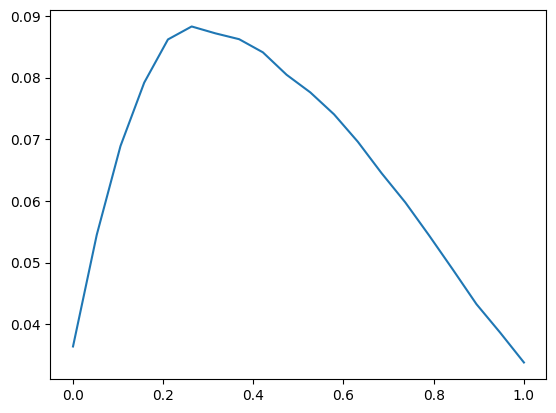

In [51]:
# compute out-of-sample R2's on validation data for a range of alphas

grid = np.linspace(0.001, 1, 20)
scores = []
for alpha in grid:
    model = Lasso(alpha=alpha)
    model.fit(X_train0, y_train0)
    scores.append(model.score(X_val, y_val))

import matplotlib.pyplot as plt
plt.plot(grid, scores)

In [64]:
# Diebold-Mariano test 

benchmark_predict = np.repeat(y_test.mean(), len(y_test))
best_alpha = grid[np.argmax(scores)]
model = Lasso(alpha=best_alpha)
model.fit(X_train, y_train)  # fit using all data other than test data
model_predict = model.predict(X_test)
dm_test(y_test, model_predict, benchmark_predict, one_sided=True)

(np.float64(-1.2498206179604558), np.float64(0.10617122764240022))

### Cross Validation

- Instead of splitting non-test observations into Train and Validate, cross-validation does the following.
- Split the 1200 points into, for example, 5 randomly chosen subsets $A, B, C, D$, and $E$.
  - Use $A \cup B \cup C \cup D$ as training data and validate on $E$.  
  - Then use $B \cup C \cup D \cup E$ as training data and validate on $A$.  
  - Then, ..., until we have trained and validated 5 times.
- Average the 5 validation scores for each model.  Choose the model with the highest average validation score.  Then test it.

### Ridge regression

In ridge regression, the coefficients are chosen to minimize
$$\text{SSE} + \text{penalty} \times \sum_{i=1}^n \beta_i^2$$
Again, the penalty is called "alpha."

Lasso will often force some coefficients to zero.  Ridge regression is unlikely to do so, because the marginal penalty goes to zero as the coefficient goes to zero.

### Exercise 

- Run train/validate using Ridge for a grid of alpha values.
- Run a Diebold-Mariano test of the best Ridge model.

### Ask Julius 

- to get the California house price data and describe it
- to build Lasso and Ridge models to predict house prices using some of the features 
- to run train/test split and use cross-validation to find the best alpha values
- to report the scores on the test data for the best alpha values